In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [3]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [4]:
CONTINUE_TRAINING = True

In [5]:
N_RUN = 1

## Load Data

In [6]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [7]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

## Networks

In [8]:
if CONTINUE_TRAINING:
    pretrained_model_D = "data/models/VGAN/MNIST/D_epoch_" + str((N_RUN-1) * 100 - 1)
    pretrained_model_G = "data/models/VGAN/MNIST/G_epoch_" + str((N_RUN-1) * 100 - 1)

In [9]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [10]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [11]:
use_cuda = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [12]:
# discriminator = DiscriminatorNet().to(device)
discriminator = DiscriminatorNet()
if CONTINUE_TRAINING:
    discriminator.load_state_dict(torch.load(pretrained_model_D, map_location='cuda'))
# discriminator.eval()     # <--- do NOT use this command to resume a training step

In [13]:
# generator = GeneratorNet().to(device)
generator = GeneratorNet()
if CONTINUE_TRAINING:
    generator.load_state_dict(torch.load(pretrained_model_G, map_location='cuda'))
# generator.eval()     # <--- do NOT use this command to resume a training step

In [14]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Optimization

In [15]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 100

## Training

In [16]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [17]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [18]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

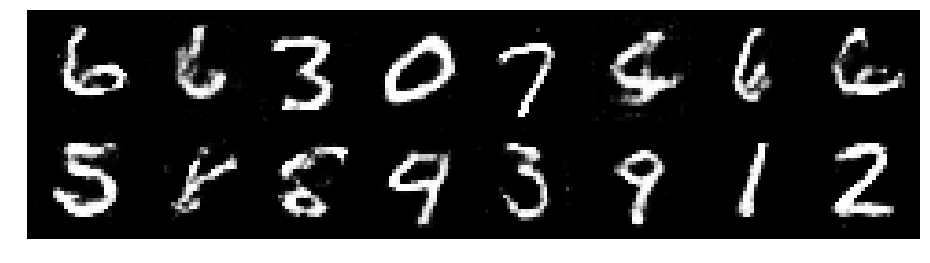

Epoch: [299/300], Batch Num: [500/600]
Discriminator Loss: 1.2773, Generator Loss: 0.8088
D(x): 0.5926, D(G(z)): 0.4814


In [19]:
logger = Logger(model_name='VGAN', data_name='MNIST')

d_error_epochs = []
g_error_epochs = []

for epoch in range((N_RUN-1) * 100, (N_RUN-1) * 100 + num_epochs):
    
    d_error_batches = []
    g_error_batches = []
    
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs * N_RUN, n_batch, num_batches,
                float(d_error), float(g_error), d_pred_real, d_pred_fake
            )
            
        d_error_batches.append(d_error.tolist())
        g_error_batches.append(g_error.tolist())
        
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
        
    d_error_epochs.append(d_error_batches)
    g_error_epochs.append(g_error_batches)

In [20]:
import numpy as np

d_pred_real_array = np.array(d_pred_real.tolist())
d_pred_real_array = d_pred_real_array.reshape(d_pred_real_array.shape[0])

d_pred_fake_array = np.array(d_pred_fake.tolist())
d_pred_fake_array = d_pred_fake_array.reshape(d_pred_fake_array.shape[0])

In [21]:
import csv

csvfile = "d_error_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(d_error_epochs)
    
csvfile = "g_error_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(g_error_epochs)
    
csvfile = "d_pred_real_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_real_array:
        writer.writerow([val])
        
csvfile = "d_pred_fake_" + str(N_RUN * 100) + ".csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in d_pred_fake_array:
        writer.writerow([val])

In [22]:
d_error_epochs_array = np.array(d_error_epochs)
new_d_error_epochs_array = np.array([np.mean(d_error_epochs_array[i,:]) for i in range(d_error_epochs_array.shape[0])])

g_error_epochs_array = np.array(g_error_epochs)
new_g_error_epochs_array = np.array([np.mean(g_error_epochs_array[i,:]) for i in range(g_error_epochs_array.shape[0])])

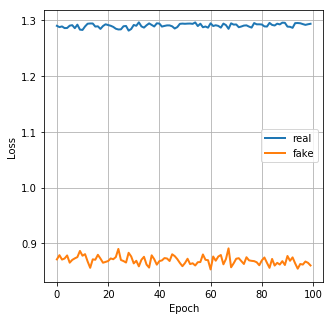

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(range(d_error_epochs_array.shape[0]), new_d_error_epochs_array, LineWidth=2, label='discriminator')
plt.plot(range(g_error_epochs_array.shape[0]), new_g_error_epochs_array, LineWidth=2, label='generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('loss_' + str(N_RUN * 100) + '.pdf', format='pdf', dpi=300)
plt.show()

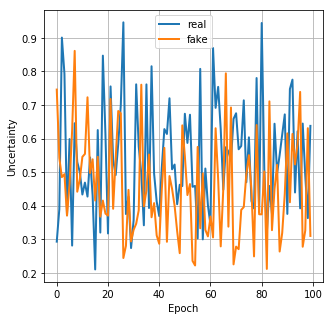

In [24]:
plt.figure(figsize=(5,5))
plt.plot(range(d_pred_real_array.shape[0]), d_pred_real_array, LineWidth=2, label='real')
plt.plot(range(d_pred_fake_array.shape[0]), d_pred_fake_array, LineWidth=2, label='fake')
plt.xlabel('Epoch')
plt.ylabel('Uncertainty')
plt.grid(True)
plt.legend()
plt.savefig('uncertainty_' + str(N_RUN * 100) + '.pdf', format='pdf', dpi=300)
plt.show()